# IMPORTING LIBRARIES

In [31]:
# IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk

from collections import Counter
from wordcloud import WordCloud
from PIL import Image
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')


In [32]:
# Ensure NLTK resources are available
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# LOADING THE DATASET

In [33]:
# Loading the data 
data = pd.read_csv('C:/Users/User/Downloads/twitter_sentiment_analysis.csv', encoding='ISO-8859-1')
data.head()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [34]:
# Rename columns for clarity
data.columns = ['Tweet', 'Brand', 'Emotion']
data

,Tweet,Brand,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


# DATA EXPLORATION

In [35]:
data.shape


(9093, 3)

In [36]:
data.columns

Index(['Tweet', 'Brand', 'Emotion'], dtype='object')

In [37]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    9092 non-null   object
 1   Brand    3291 non-null   object
 2   Emotion  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [38]:
data.isna().sum()


Tweet         1
Brand      5802
Emotion       0
dtype: int64

In [39]:
# View sentiment distribution
print(data['Emotion'].value_counts())


No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: Emotion, dtype: int64


In [40]:
import nltk
from nltk.corpus import stopwords

# Initialize the lemmatizer and stemmer
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.PorterStemmer()

def preprocess_text(text):
    # Check if text is a string, if not, convert it to an empty string
    if not isinstance(text, str):
        return ""
    
    # Tokenize and remove stopwords
    words = text.split()
    stop_words = set(stopwords.words('english'))
    
    # Lemmatize and stem the words
    words = [lemmatizer.lemmatize(w) for w in words if w.lower() not in stop_words]
    words = [stemmer.stem(w) for w in words]
    
    # Return the processed text
    return ' '.join(words)

# Ensure stopwords are downloaded
nltk.download('stopwords')

# Apply the preprocess function to the 'Tweet' column
data['processed_text'] = data['Tweet'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# Convert non-string values to empty strings in the 'tweet_text' column
data['Tweet'] = data['Tweet'].fillna('')

# Ensure all entries are strings
data['Tweet'] = data['Tweet'].astype(str)

# Tokenize the text and get word frequency
words = ' '.join(data['Tweet']).split()
word_freq = Counter(words)

# Display the most common words
print(word_freq.most_common(10))


[('@mention', 6703), ('{link}', 4255), ('#sxsw', 4013), ('the', 3887), ('#SXSW', 3643), ('to', 3496), ('RT', 2883), ('at', 2842), ('for', 2432), ('a', 2158)]


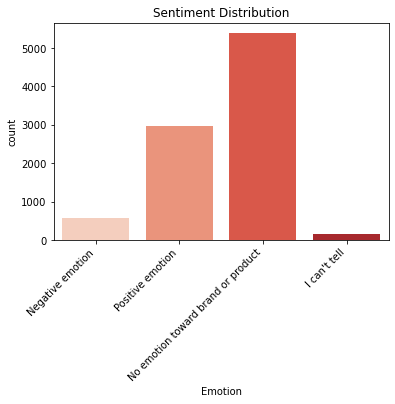

In [42]:
# plot sentiment distribution
sns.countplot(data=data, x='Emotion', palette='Reds')
plt.title('Sentiment Distribution')
plt.xticks(rotation=45, ha='right')  
plt.show()



In [43]:
data.duplicated().sum()


22

In [44]:
data[data.duplicated()].head()


,Tweet,Brand,Emotion,processed_text
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion,"even begins, appl win #sxsw {link}"
776,Google to Launch Major New Social Network Call...,NaN,No emotion toward brand or product,googl launch major new social network call cir...
2232,Marissa Mayer: Google Will Connect the Digital...,NaN,No emotion toward brand or product,marissa mayer: googl connect digit &amp; physi...
2559,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,count day #sxsw plu strong canadian dollar mea...
3950,Really enjoying the changes in Gowalla 3.0 for...,Android App,Positive emotion,realli enjoy chang gowalla 3.0 android! look f...


In [45]:
data = data.dropna(subset=['Tweet'])


In [46]:

data['Brand'].fillna("No Brand", inplace = True)
data.isna().sum()

Tweet             0
Brand             0
Emotion           0
processed_text    0
dtype: int64

In [47]:
emotion = {'Positive emotion': 'Positive', 'Negative emotion': 'Negative', 
                'No emotion toward brand or product': 'Neutral', 
                "I can't tell": 'Unknown'}
data['Emotion'] = data['Emotion'].map(emotion)
data.head()

,Tweet,Brand,Emotion,processed_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,".@wesley83 3G iphone. 3 hr tweet #rise_austin,..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,@jessede know @fludapp ? awesom ipad/iphon app...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,@swonderlin wait #ipad 2 also. sale #sxsw.
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,@sxsw hope year' festiv crashi year' iphon app...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,@sxtxstate great stuff fri #sxsw: marissa maye...


In [48]:
data['Emotion'].value_counts()


Neutral     5389
Positive    2978
Negative     570
Unknown      156
Name: Emotion, dtype: int64

In [49]:
# Dropping the "Unknown" sentiment
data = data[data['Emotion']!='Unknown']
data['Emotion'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: Emotion, dtype: int64

# PREPROCESSING

In [50]:
# Clean tweet text
def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)        # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)     # Remove special characters
    return text.lower().strip()

data['Tweet'] = data['Tweet'].fillna('').apply(clean_text)

In [51]:

lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.PorterStemmer()

def preprocess_text(text):
    words = text.split()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    words = [stemmer.stem(w) for w in words]
    return ' '.join(words)

data['processed_text'] = data['Tweet'].apply(preprocess_text)

In [52]:
data['Tweet'] = data['Tweet'].fillna('')


In [53]:
data['Tweet'] = data['Tweet'].apply(clean_text)


In [54]:
print(data.head())
print(data['Emotion'].value_counts())


                                               Tweet               Brand  \
0  i have a g iphone after  hrs tweeting at risea...              iPhone   
1  know about   awesome ipadiphone app that youll...  iPad or iPhone App   
2  can not wait for ipad  also they should sale t...                iPad   
3  i hope this years festival isnt as crashy as t...  iPad or iPhone App   
4  great stuff on fri sxsw marissa mayer google t...              Google   

    Emotion                                     processed_text  
0  Negative  g iphon hr tweet riseaustin dead need upgrad p...  
1  Positive  know awesom ipadiphon app youll like appreci d...  
2  Positive                           wait ipad also sale sxsw  
3  Negative   hope year festiv isnt crashi year iphon app sxsw  
4  Positive  great stuff fri sxsw marissa mayer googl tim o...  
Neutral     5389
Positive    2978
Negative     570
Name: Emotion, dtype: int64


In [55]:
# Preprocess text (lemmatization & stemming)
# Download required NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional for multilingual support
nltk.download('punkt')     # Optional for tokenization

from nltk.stem import WordNetLemmatizer, PorterStemmer

# Initialize the lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Your preprocessing function goes here

# Initialize the lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Function for preprocessing
def preprocess_text(text):
    # Remove special characters and convert to lowercase
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    
    # Tokenize the text
    words = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    
    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    # Stemming
    stemmed_words = [stemmer.stem(word) for word in lemmatized_words]
    
    return ' '.join(stemmed_words)

# Apply preprocessing to the 'Tweet' column
data['processed_text'] = data['Tweet'].apply(preprocess_text)

# Display the processed text
print(data[['Tweet', 'processed_text']].head())


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                               Tweet  \
0  i have a g iphone after  hrs tweeting at risea...   
1  know about   awesome ipadiphone app that youll...   
2  can not wait for ipad  also they should sale t...   
3  i hope this years festival isnt as crashy as t...   
4  great stuff on fri sxsw marissa mayer google t...   

                                      processed_text  
0  g iphon hr tweet riseaustin dead need upgrad p...  
1  know awesom ipadiphon app youll like appreci d...  
2                           wait ipad also sale sxsw  
3   hope year festiv isnt crashi year iphon app sxsw  
4  great stuff fri sxsw marissa mayer googl tim o...  


# FEATURE ENGINEERING

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Step 1: Convert processed text to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X = tfidf_vectorizer.fit_transform(data['processed_text']).toarray()

# Step 2: Encode sentiment labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Emotion'])

# Display the shapes of the feature and label arrays
print(f"Feature shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Optionally, display the first few feature names
print(tfidf_vectorizer.get_feature_names_out()[:10])  # Display the first 10 feature names


Feature shape: (8937, 5000)
Labels shape: (8937,)
['aapl' 'aaron' 'ab' 'abacu' 'abba' 'abc' 'abil' 'abl' 'abnorm' 'absolut']


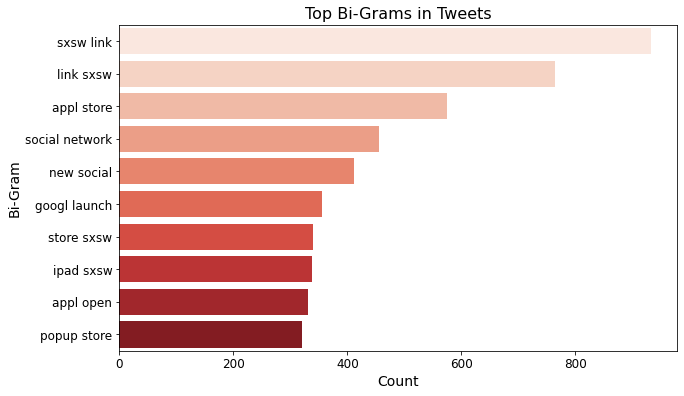

In [48]:
df = pd.DataFrame(data)

# Step 2: Extract Bi-Grams
vectorizer = CountVectorizer(ngram_range=(2, 2))  # Change to (3, 3) for tri-grams
X_ngrams = vectorizer.fit_transform(df['processed_text'])

# Step 3: Count the n-grams and sort them
ngram_counts = X_ngrams.sum(axis=0).A1
ngrams = vectorizer.get_feature_names_out()
top_ngrams = pd.DataFrame(ngram_counts, index=ngrams, columns=['Count']).sort_values(by='Count', ascending=False).head(10)

# Step 4: Create the Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_ngrams['Count'], y=top_ngrams.index, palette='Reds')
plt.title('Top Bi-Grams in Tweets', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Bi-Gram', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


# Step 1: Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Train a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 4: Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Confusion Matrix:
[[ 10  81  23]
 [  1 947 130]
 [  0 314 282]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.09      0.16       114
     Neutral       0.71      0.88      0.78      1078
    Positive       0.65      0.47      0.55       596

    accuracy                           0.69      1788
   macro avg       0.75      0.48      0.50      1788
weighted avg       0.70      0.69      0.66      1788



In [50]:
# Sample a smaller dataset for testing
data_sample = data.sample(frac=0.1, random_state=42)  # Use 10% of the data
X = tfidf_vectorizer.fit_transform(data_sample['processed_text']).toarray()
y = label_encoder.fit_transform(data_sample['Emotion'])

# Class Balancing using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Smaller hyperparameter grid
param_grid = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=2, scoring='f1_weighted', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and evaluation...


Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [100]},
             scoring='f1_weighted', verbose=2)

In [51]:
# Best parameters found
print("Best parameters found: ", grid_search.best_params_)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_rf_model.predict(X_test)

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Confusion Matrix:
[[98  7  3]
 [ 0 96 13]
 [ 0 37 72]]

Classification Report:
              precision    recall  f1-score   support

    Negative       1.00      0.91      0.95       108
     Neutral       0.69      0.88      0.77       109
    Positive       0.82      0.66      0.73       109

    accuracy                           0.82       326
   macro avg       0.83      0.82      0.82       326
weighted avg       0.83      0.82      0.82       326



In [52]:
# handling misclassification
misclassified_indices = np.where(y_test != y_pred)[0]
misclassified = data.iloc[misclassified_indices]  # Use the original data to get full details
misclassified['Predicted Emotion'] = label_encoder.inverse_transform(y_pred[misclassified_indices])  # Add predicted emotion
misclassified['True Emotion'] = label_encoder.inverse_transform(y_test[misclassified_indices])  # Add true emotion

# Display the misclassified examples
print(misclassified[['processed_text', 'True Emotion', 'Predicted Emotion']])


                                        processed_text True Emotion  \
23             photo instal sxsw iphon app realli nice     Positive   
27   someon start austin group googl group presxsw ...      Neutral   
32   attn sxsw frine regist gdgtlive see cobra irad...      Neutral   
37   spin play new concept music discoveri ipad amp...     Positive   
38   fals alarm googl circl come nowand probabl eve...      Neutral   
46   handheld hobo drafthous launch hobo shotgun ip...      Neutral   
48   orli googl set launch new social network circl...     Positive   
49   wooooo appl store downtown austin open til mid...     Positive   
55   talk link googl effort allow user open system ...     Positive   
57   link rt st stop sxsw chao amp hunt austin java...      Neutral   
63   smile rt think appl quotpopup storequot austin...     Negative   
65   agre rt wait fiona appl town somebodi kidnap p...     Positive   
71   chilcott sxsw stand talk blogger staff late wi...     Positive   
73   g

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

# Example of n-grams
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000)
X_ngrams = ngram_vectorizer.fit_transform(data_sample['processed_text']).toarray()


# MODEL BUILDING

In [54]:
from xgboost import XGBClassifier

# Sample XGBoost implementation
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


[17:31:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




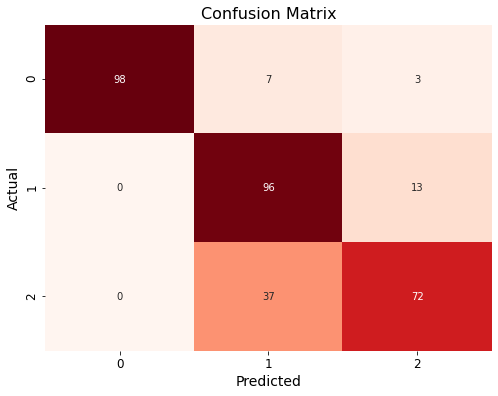

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [56]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_distributions, n_iter=100, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   scoring='f1_weighted', verbose=2)

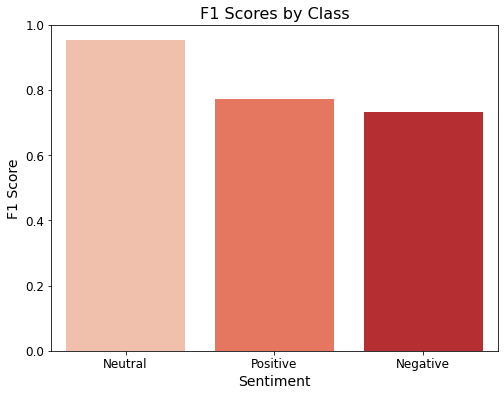

In [59]:
# Import necessary libraries
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your GridSearchCV object is named 'grid_search'
best_model = grid_search.best_estimator_

# Now you can use the best model to make predictions
y_pred = best_model.predict(X_test)

# Calculate F1 scores for each class (e.g., Neutral, Positive, Negative)
f1_scores = f1_score(y_test, y_pred, average=None)

# Define the class labels (adjust based on your dataset)
class_labels = ['Neutral', 'Positive', 'Negative']  # Change if needed

# Plot F1 scores for each class
plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=f1_scores, palette='Reds')
plt.title('F1 Scores by Class', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.show()



In [60]:
from sklearn.model_selection import cross_val_score

# Use the best model found during GridSearchCV
best_model = grid_search.best_estimator_

# Perform cross-validation
scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, scoring='f1_weighted')
print("Cross-validated F1 score:", scores.mean())


Cross-validated F1 score: 0.8421583396783646


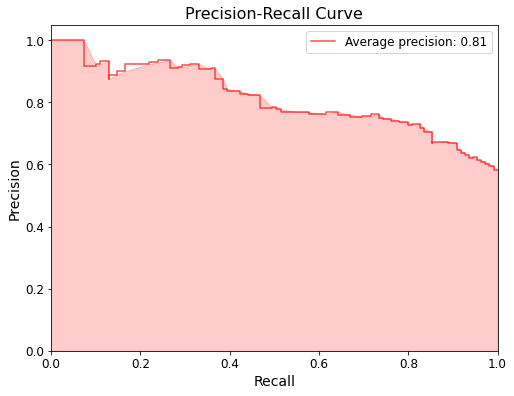

In [62]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming best_model is already defined and fitted
# Get predicted probabilities for each class
y_scores = best_model.predict_proba(X_test)  # This returns probabilities for each class

# One-hot encode y_test for multi-class classification
encoder = OneHotEncoder(sparse=False)
y_test_binarized = encoder.fit_transform(y_test.reshape(-1, 1))

# Calculate average precision for each class (adjust the index for each class)
average_precision = average_precision_score(y_test_binarized[:, 1], y_scores[:, 1])  # Change index for other classes
precision, recall, _ = precision_recall_curve(y_test_binarized[:, 1], y_scores[:, 1])  # Change index for other classes

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', color='red', alpha=0.7,
         label='Average precision: {0:0.2f}'.format(average_precision))
plt.fill_between(recall, precision, alpha=0.2, color='red')
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.show()


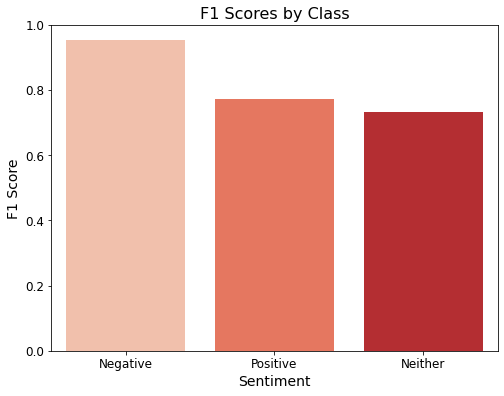

In [63]:
from sklearn.metrics import f1_score

# Assuming y_test and y_pred are defined
f1_scores = f1_score(y_test, y_pred, average=None)  # Compute F1 scores for each class

plt.figure(figsize=(8, 6))
sns.barplot(x=['Negative', 'Positive', 'Neither'], y=f1_scores, palette='Reds')
plt.title('F1 Scores by Class', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)
plt.show()


In [44]:

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


[13:53:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Confusion Matrix:
[[107   0   1   1]
 [  0 104   3   1]
 [  0   1  84  24]
 [  0   0  30  79]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       109
           1       0.99      0.96      0.98       108
           2       0.71      0.77      0.74       109
           3       0.75      0.72      0.74       109

    accuracy                           0.86       435
   macro avg       0.86      0.86      0.86       435
weighted avg       0.86      0.86      0.86       435

